In [3]:
import requests
import pandas as pd
import json
import numpy as np
from datetime import datetime
import random

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import time

In [4]:
Token = 'AlqqRRARtlHqvSYHrikULRAlFDxiZUFa'

In [5]:
target_data_types = {
     'PRCP': 'Precipitation',
     'SNOW': 'Snowfall',
     'SNWD': 'Snow depth',
     'TAVG': 'Average Temperature',
     'TMAX': 'Maximum temperature',
     'TMIN': 'Minimum temperature',
#  'AWND': 'Average wind speed'
                    }

targets = target_data_types.keys()

In [6]:
# import dataset that include all the GHCND stations
station_inventory = pd.read_csv('ghcnd-inventory.txt',header=None,index_col=None,delim_whitespace=True,names=['id','lat','lon','datatype','date_start','date_end'])

station_inventory.info()
# There are 704214 rows in total

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704214 entries, 0 to 704213
Data columns (total 6 columns):
id            704214 non-null object
lat           704214 non-null float64
lon           704214 non-null float64
datatype      704214 non-null object
date_start    704214 non-null int64
date_end      704214 non-null int64
dtypes: float64(2), int64(2), object(2)
memory usage: 32.2+ MB


In [7]:
# since one station could appear multiple times because of variety of datatypes for each station. Keep stations with our target datatypes.
stations = station_inventory[station_inventory['datatype'].isin(targets)].reset_index(drop=True)

stations.info()
# 338326 left

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337132 entries, 0 to 337131
Data columns (total 6 columns):
id            337132 non-null object
lat           337132 non-null float64
lon           337132 non-null float64
datatype      337132 non-null object
date_start    337132 non-null int64
date_end      337132 non-null int64
dtypes: float64(2), int64(2), object(2)
memory usage: 15.4+ MB


In [8]:
# Since not every station has all the target datatype, using pivot table to count each datatype for each station
stations_count = pd.pivot_table(stations, index='id', columns='datatype', aggfunc='size', fill_value=0)

# since thre is a BUG to do margins when agg_func is size, manually sum each row
stations_count['sum'] = stations_count.sum(axis=1)

# keeps those stations with all the target datatypem which mean sum == 6

stations_id = stations_count[stations_count['sum'] == 6].index

In [9]:
# find out what countries are included this 1676 staions
# the first two character represents the country, I found a datasets that include all the country info
ghcnd_countries = pd.read_fwf('ghcnd-countries.txt',header=None,names=['code','country'])

# extrac the first two characters of the 1676 staions
stations_id = pd.DataFrame(stations_id)
stations_id['code'] = stations_id['id'].map(lambda x:x[0:2])

# merge with ghcnd_countries
stations_id = pd.merge(stations_id,ghcnd_countries,how='left',on='code')

In [10]:
stations_final = []
unique_countries = list(stations_id['country'].unique())
for i in unique_countries:
    ids = list(stations_id[stations_id['country'] == i]['id'])
    stations_final.append(random.sample(ids,1))

In [11]:
random.seed(33)
print(stations_id['country'].value_counts())
# most of the stations are from Canada and US. 
#In order to have our data represent the global weather. keep one station for each of those countries

stations_final = []
unique_countries = list(stations_id['country'].unique())
for i in unique_countries:
    ids = list(stations_id[stations_id['country'] == i]['id'])
    stations_final.append(random.choice(ids))

Canada                             862
United States                      776
Spain                                4
Federated States of Micronesia       3
Antarctica                           3
Vietnam                              2
Marshall Islands                     2
Virgin Islands [United States]       2
Germany                              2
Japan                                1
Palau                                1
Puerto Rico [United States]          1
American Samoa [United States]       1
Cayman Islands [United Kingdom]      1
United Kingdom                       1
Greenland [Denmark]                  1
Italy                                1
Thailand                             1
Iceland                              1
Solomon Islands                      1
Portugal                             1
Guyana                               1
Bermuda [United Kingdom]             1
Laos                                 1
Morocco                              1
Cuba                     

In [12]:
# create the final staions list including id, lat, lon, country,
stations_lat_lon = stations[['id','lat','lon']].drop_duplicates().reset_index(drop=True)

# merge stations_final with stations_lat_lon & stations_id to get lat, lon and country name
# convert stations_final to DataFrame first
stations_final = pd.DataFrame(stations_final,columns=['id'])
stations_final = pd.merge(stations_final, stations_lat_lon, how='left', on='id')
stations_final = pd.merge(stations_final, stations_id, how='left', on='id')

In [13]:
stations_final

,id,lat,lon,code,country
0,AQW00061705,-14.3306,-170.7136,AQ,American Samoa [United States]
1,AYW00090001,-90.0000,0.0000,AY,Antarctica
2,BDM00078016,32.3667,-64.6833,BD,Bermuda [United Kingdom]
3,BPW00080601,-9.4333,160.0500,BP,Solomon Islands
4,CA004047644,52.3167,-107.7667,CA,Canada
5,CJW00011813,19.3000,-81.3667,CJ,Cayman Islands [United Kingdom]
6,CUW00011706,19.9000,-75.1500,CU,Cuba
7,FMW00040505,7.4500,151.8333,FM,Federated States of Micronesia
8,GLW00017605,76.5167,-68.8333,GL,Greenland [Denmark]
9,GMW00035032,50.0333,8.5833,GM,Germany


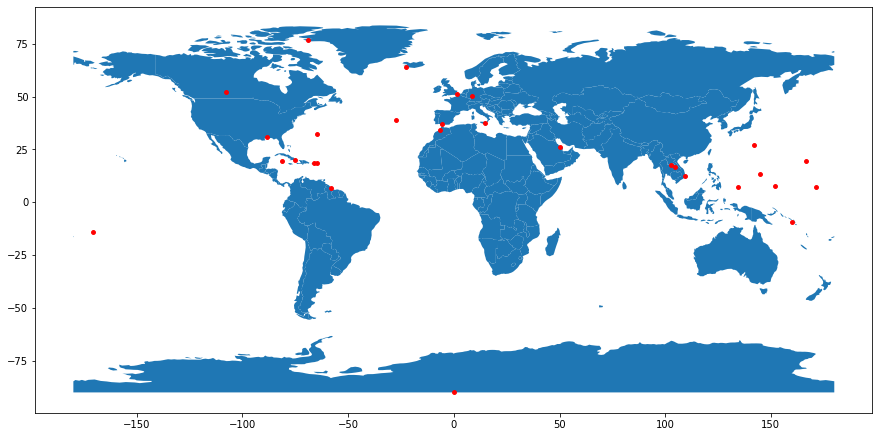

In [14]:
# plot those stations on map
geometry = [Point(xy) for xy in zip(stations_final['lon'], stations_final['lat'])]
gdf = GeoDataFrame(geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(15, 9)), marker='o', color='red', markersize=15);

In [15]:
# stations_final.to_csv('stations_final.csv',index=False)

In [16]:
# api function for getting the data
def get_data(station_info, start_year, end_year):
    the_count = 1
    df_base = pd.DataFrame(columns=['date','TAVG','TMAX','TMIN','PRCP','SNOW','SNWD','station_id','lat','lon','code','country'])
    the_length = len(station_info)
    day_month_info = pd.DataFrame({'start_month':[1,5,9],'end_month':[4,8,12],'days':[30,31,31]})
    
    for i in range(0,the_length):
        # get the station info for each ieration
        the_station = stations_final.loc[i,]
        station_id = 'GHCND:'+the_station['id']
        the_lat = the_station['lat']
        the_lon = the_station['lon']
        the_code = the_station['code']
        the_country = the_station['country']

        for year in range(start_year, end_year+1):
            for q in range(0,3):
                temp = day_month_info.loc[q,]
                days = temp['days']
                year = str(year)
                start_month = str(temp['start_month']).zfill(2)
                end_month = str(temp['end_month']).zfill(2)


                #make the api call
                r = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TAVG,TMAX,TMIN,PRCP,SNOW,SNWD&units=metric&limit=1000&stationid='+station_id+'&startdate='+year+'-'+start_month+'-01&enddate='+year+'-'+end_month+'-'+str(days), headers={'token':Token})
                res = json.loads(r.text)
                # show how my request had been made
                the_count += 1
                time.sleep(0.3)
                
                try:
                    current_table = pd.DataFrame(res['results'])
                    current_table = pd.DataFrame(pd.pivot_table(current_table,index='date',columns='datatype',values='value')).reset_index().rename(columns={'index':'date'})
                    current_table['station_id'] = station_id
                    current_table['lat'] = the_lat
                    current_table['lon'] = the_lon
                    current_table['code'] = the_code
                    current_table['country'] = the_country
                    
                    df_base = df_base.append(current_table,sort=False)
                    
                except:
                    pass
                    
    print(f'{the_count} requests had been made')         
    return df_base

In [17]:
all_1990_1999 = get_data(stations_final, 1990, 1999)

871 requests had been made


In [18]:
# all_1990_1999.to_csv('all_1990_1999.csv',index=False)

In [19]:
all_1970_1989 = get_data(stations_final, 1970, 1989)

1741 requests had been made


In [21]:
# all_1970_1989.to_csv('all_1970_1989.csv',index=False)

In [22]:
all_1970_1989.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177724 entries, 0 to 121
Data columns (total 12 columns):
date          177724 non-null object
TAVG          69082 non-null object
TMAX          150990 non-null float64
TMIN          145337 non-null float64
PRCP          141912 non-null float64
SNOW          106060 non-null float64
SNWD          106199 non-null float64
station_id    177724 non-null object
lat           177724 non-null float64
lon           177724 non-null float64
code          177724 non-null object
country       177724 non-null object
dtypes: float64(7), object(5)
memory usage: 17.6+ MB
